# Домашнее задание №2.
## Метод главных компонент

---
**Выполнила:** Халфина Айсылу Зуфаровна

**Группа:** НПМбд-02-19

---

**Цель работы:**  реализовать метод главных компонент, позволяющий выделять наиболее существенную информацию из данных с помощью линейных преобразований и с помощью него и алгоритма k-ближайших соседей решить задачу распознавания рукописных цифр.

## Выполнение
Первым делом импортируем необходимые вспомогательные библиотеки

In [70]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 1. Датасет
Скачаем датасет **digits** при помощи функции **load_digits** из пакета **sklearn.datasets**. Получим массив картинок в виде массива **X**, а также ответов **labels**.
При помощи функции **matplotlib.pyplot.imshow** нарисуем несколько примеров картинок из X.

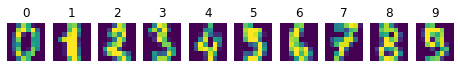

In [71]:
digits = load_digits()
X = digits.data
labels = digits.target

fig, ax = plt.subplots(1, 10, figsize=(8, 8))
for i in range(10):
    ax[i].imshow(digits.images[i])
    ax[i].set_title(labels[i])
    ax[i].axis('off')

### 2. Алгоритм PCA
Метод главных компонент состоит из следующих 4-х шагов: 
- Центрирование данных: $X_c = X - \overline{X}$ , где $X$ – среднее для каждого параметра
- Вычисление матрицы ковариации: $C = X^T_c X_c$
 
- Вычисление собственных векторов $F$ и значений $\lambda$ матрицы ковариации $C$. 
- Преобразование данных в координаты в базисе главных компонент: $Y = X_c F$

Реализуем три шага внутри метода **fit()**, и шаг 4 внутри метода **transform()** класса **my_PCA**.


In [72]:
class my_PCA(): 
    def __init__(self, n_components=None):
        self.n_components = n_components    
    
    def fit(self, X): 
        Xc = X
        Xc -= X.mean(axis=0)
        C = Xc.T.dot(Xc)
        lambda_, F = np.linalg.eigh(C)
        lambda_ = lambda_[::-1]
        F = F[:, ::-1]
        
        return Xc, F, lambda_     
    
    def transform(self, X, F): 
        return X.dot(F)
    
    def fit_transform(self, X):
        X_c, F, _ = self.fit(X)
        Y = self.transform(X_c, F)
        if self.n_components != None:
            Y = Y[:, :self.n_components]
        return Y

Построим график собственных значений, а также график отношения кумулятивной суммы к их полной сумме.

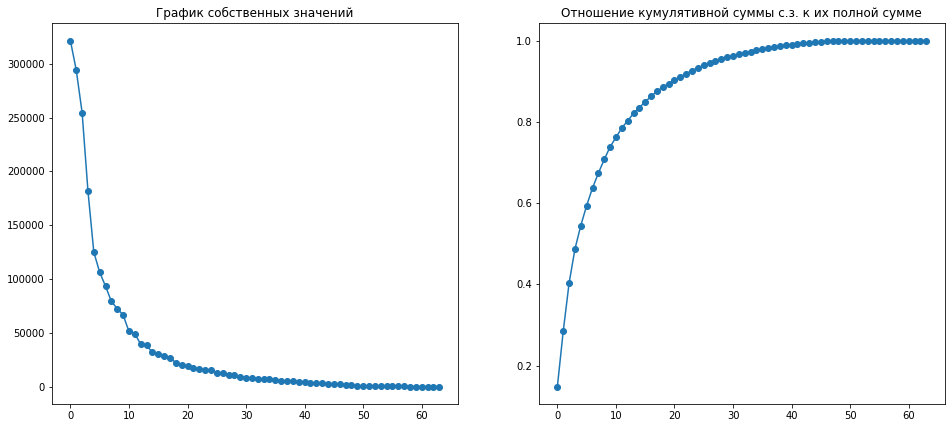

In [83]:
eig = my_PCA().fit(X)[2]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16, 7))
eig_sum = np.sum(eig)
eig_cumsum = np.cumsum(eig)

axes[0].plot(eig, 'o-')
axes[0].set_title('График собственных значений')
axes[1].plot(eig_cumsum / eig_sum, 'o-')
axes[1].set_title('Отношение кумулятивной суммы с.з. к их полной сумме');

Изобразим на графике точки датасета в первых двух координатах главных компонент. Каждой цифре соответствует свой цвет.

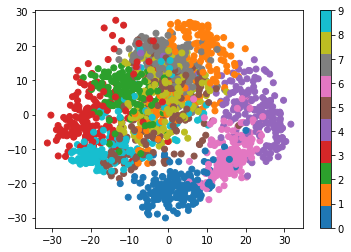

In [90]:
Y = my_PCA().fit_transform(X)
plt.scatter(Y[:,0], Y[:,1], c = labels, cmap = 'tab10')
plt.colorbar();

По графику видно, что точки, принадлежащие разным классам, сгруппированы. Некоторый разброс наблюдается, но в целом групировка достаточно явная.

### 3. Алгоритм kNN

Реализуем метод k-ближайших соседей в виде класса **my_kNN**.

In [91]:
class my_kNN(): 
    def __init__(self, n_neighbors=5): 
        self.n_neighbors = n_neighbors  
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X): 
        classes = list()
        for point in X:
            norms = list()

            for point_train in self.X_train:
                norm = np.linalg.norm(np.array(point) - np.array(point_train)) 
                norms.append(norm)
                
            norms_sort = np.argsort(norms)
            minimum_norms = norms_sort[:self.n_neighbors]
            object_class = list()
            
            for j in minimum_norms:
                object_class.append(self.y_train[j])
                
            object_class_set = set(object_class)
            our_class = None 
            c_our_class = 0

            for k in object_class_set:
                c = object_class.count(k)
                if c > c_our_class:
                    c_our_class = c 
                    our_class = k 

            classes.append(our_class)
        return classes

Создадим функцию, которая будет разбивать данные **X** и **labels** на обучающую и тестовую выборку, используя функцию **train_test_split** из модуля **sklearn.model_selection** и считать точность тестовой выборки при разных количествах компонент.

In [145]:
def test_dataset(dataset):
    X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size = 1500, random_state = 42)

    for i in range (1, 31, 4):
        kNN = my_kNN(i)
        kNN.fit(X_train, y_train)
        classes = kNN.predict(X_test)
        accuracy = accuracy_score(y_test, classes) * 100
        print("Количество соседей:", i, "Точность:", accuracy)

Проверим точность вычислений на выборке без использования метода метода главных компонент.

In [146]:
test_dataset(X)

Количество соседей: 1 Точность: 96.2
Количество соседей: 5 Точность: 94.66666666666667
Количество соседей: 9 Точность: 92.46666666666667
Количество соседей: 13 Точность: 91.46666666666667
Количество соседей: 17 Точность: 90.73333333333333
Количество соседей: 21 Точность: 89.4
Количество соседей: 25 Точность: 88.13333333333333
Количество соседей: 29 Точность: 86.53333333333333


Как видим, точность привышает требуемые 10%. Делаем вывод, что алгоритм работает верно. Теперь будем применять метод главных компонент. Будем менять количество от 1 до 64.

In [147]:
PCA = my_PCA(1)
Y = PCA.fit_transform(X)

test_dataset(Y)

Количество соседей: 1 Точность: 26.666666666666668
Количество соседей: 5 Точность: 29.46666666666667
Количество соседей: 9 Точность: 32.266666666666666
Количество соседей: 13 Точность: 32.666666666666664
Количество соседей: 17 Точность: 33.33333333333333
Количество соседей: 21 Точность: 34.53333333333333
Количество соседей: 25 Точность: 36.0
Количество соседей: 29 Точность: 35.46666666666667


In [148]:
PCA = my_PCA(3)
Y = PCA.fit_transform(X)

test_dataset(Y)

Количество соседей: 1 Точность: 69.53333333333333
Количество соседей: 5 Точность: 74.6
Количество соседей: 9 Точность: 74.4
Количество соседей: 13 Точность: 73.4
Количество соседей: 17 Точность: 73.06666666666666
Количество соседей: 21 Точность: 72.86666666666667
Количество соседей: 25 Точность: 72.86666666666667
Количество соседей: 29 Точность: 72.53333333333333


In [149]:
PCA = my_PCA(5)
Y = PCA.fit_transform(X)

test_dataset(Y)

Количество соседей: 1 Точность: 85.46666666666667
Количество соседей: 5 Точность: 88.46666666666667
Количество соседей: 9 Точность: 87.2
Количество соседей: 13 Точность: 87.0
Количество соседей: 17 Точность: 85.46666666666667
Количество соседей: 21 Точность: 85.39999999999999
Количество соседей: 25 Точность: 84.53333333333333
Количество соседей: 29 Точность: 83.8


In [150]:
PCA = my_PCA(10)
Y = PCA.fit_transform(X)

test_dataset(Y)

Количество соседей: 1 Точность: 93.26666666666667
Количество соседей: 5 Точность: 91.8
Количество соседей: 9 Точность: 89.93333333333334
Количество соседей: 13 Точность: 89.06666666666668
Количество соседей: 17 Точность: 88.2
Количество соседей: 21 Точность: 87.2
Количество соседей: 25 Точность: 87.4
Количество соседей: 29 Точность: 86.93333333333332


In [151]:
PCA = my_PCA(15)
Y = PCA.fit_transform(X)

test_dataset(Y)

Количество соседей: 1 Точность: 95.39999999999999
Количество соседей: 5 Точность: 94.19999999999999
Количество соседей: 9 Точность: 91.93333333333334
Количество соседей: 13 Точность: 90.60000000000001
Количество соседей: 17 Точность: 90.06666666666666
Количество соседей: 21 Точность: 89.53333333333333
Количество соседей: 25 Точность: 88.46666666666667
Количество соседей: 29 Точность: 87.46666666666667


In [152]:
PCA = my_PCA(30)
Y = PCA.fit_transform(X)

test_dataset(Y)

Количество соседей: 1 Точность: 96.46666666666667
Количество соседей: 5 Точность: 94.73333333333333
Количество соседей: 9 Точность: 92.93333333333334
Количество соседей: 13 Точность: 91.46666666666667
Количество соседей: 17 Точность: 90.26666666666667
Количество соседей: 21 Точность: 90.0
Количество соседей: 25 Точность: 88.4
Количество соседей: 29 Точность: 87.0


In [153]:
PCA = my_PCA(64)
Y = PCA.fit_transform(X)

test_dataset(Y)

Количество соседей: 1 Точность: 96.26666666666667
Количество соседей: 5 Точность: 94.66666666666667
Количество соседей: 9 Точность: 92.46666666666667
Количество соседей: 13 Точность: 91.4
Количество соседей: 17 Точность: 90.73333333333333
Количество соседей: 21 Точность: 89.4
Количество соседей: 25 Точность: 88.06666666666668
Количество соседей: 29 Точность: 86.53333333333333
